### Importing Libraries and mounting google drive





In [ ]:
# Google Colab setup
!pip install tensorflow scipy h5py
import tensorflow as tf
from tensorflow.keras import backend as bknd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Reshape, Flatten, Input, Concatenate, Dropout, LSTM, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining The paths

In [ ]:
# Define paths
train_loc = '/content/drive/MyDrive/output_imagesSNR5/train_4000'
test_loc = '/content/drive/MyDrive/output_imagesSNR5/test'
weights_path = '/content/drive/MyDrive/CWT/model_weightsProject.keras'
history_path = '/content/drive/MyDrive/CWT/model_historyProject.csv'


## Displaying the Number of images in train and test

In [ ]:
# Data generators
trdata = ImageDataGenerator(rescale=1./255)
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224, 224), batch_size=16)
tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224, 224), batch_size=16)

print("Number of training samples:", len(traindata.filenames))
print("Number of testing samples:", len(testdata.filenames))


Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Number of training samples: 800
Number of testing samples: 200


## NRC-NET Architechture

In [ ]:
# Model architecture definition
inputShape = Input((224, 224, 3))  # Input shape (224,224,3)

# CNN layers
conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputShape)
x_inputi = BatchNormalization()(conv_1)
conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_inputi)
conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2)
batchnorm_3 = BatchNormalization()(conv_3)
x_inputi = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)

conv_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_inputi)
conv_5 = Conv2D(96, (5, 5), activation='relu', padding='same')(conv_4)
batchnorm_5 = BatchNormalization()(conv_5)
x_inputi = MaxPooling2D(pool_size=(2, 2))(batchnorm_5)

# Concatenate branches
x_in1i = Conv2D(filters=int(x_inputi.shape[-1] // 4), kernel_size=(1, 1), activation='relu')(x_inputi)
x_in1i = BatchNormalization()(x_in1i)
x_in3i = Conv2D(filters=int(x_inputi.shape[-1] // 2), kernel_size=(3, 3), padding='same', activation='relu')(x_in1i)
x_in3i = BatchNormalization()(x_in3i)
out = Concatenate()([x_in1i, x_in3i])

# LSTM
# Use .shape instead of .get_shape() to access the symbolic shape
bn_shape = out.shape
x_reshape = Reshape(target_shape=(int(bn_shape[1]), int(bn_shape[2] * bn_shape[3])))(out)
fc_1 = Dense(128, activation='relu')(x_reshape)
rnn_1 = LSTM(32, kernel_initializer="he_normal", return_sequences=True)(fc_1)
rnn_1b = LSTM(32, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(fc_1)
rnn1_merged = add([rnn_1, rnn_1b])

# Fully connected layers
drop_1 = Dropout(0.25)(rnn1_merged)
classifier = Flatten()(drop_1)
fc_2 = Dense(128, activation='relu')(classifier)
outputLayer = Dense(5, activation='softmax')(fc_2)

# # Model setup
# base_model = Model(inputs=inputShape, outputs=outputLayer)
# base_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# # Callbacks
# checkpoint = ModelCheckpoint(weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
# callbacks_list = [checkpoint, es]

# # Training the model
# history = base_model.fit(traindata, validation_data=testdata, epochs=60, callbacks=callbacks_list)
# # Save history to CSV
# hist_df = pd.DataFrame(history.history)
# hist_df.to_csv(history_path, index=False)



## Model Training

In [ ]:
# Compile the model
base_model = Model(inputs=inputShape, outputs=outputLayer)
base_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
callbacks_list = [checkpoint, es]

# Train the model
history = base_model.fit(
    traindata,
    validation_data=testdata,  # Pass validation data here
    epochs=60,
    verbose=1,  # Ensure verbose is set to 1 to display logs
    callbacks=callbacks_list
)




Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4328 - loss: 1.3706
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to /content/drive/MyDrive/CWT/model_weightsProject.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 414s 7s/step - accuracy: 0.4362 - loss: 1.3643 - val_accuracy: 0.2000 - val_loss: 1.6410
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8935 - loss: 0.3499
Epoch 2: val_accuracy did not improve from 0.20000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.8939 - loss: 0.3486 - val_accuracy: 0.2000 - val_loss: 1.7207
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9762 - loss: 0.1069
Epoch 3: val_accuracy did not improve from 0.20000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.9764 - loss: 0.1065 - val_accuracy: 0.2000 - val_loss: 1.7784
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9951 - loss: 0.0463
Epoch 4: val_accuracy did not improve from 0.20000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step 

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/CWT/history'

In [ ]:
# Save history to CSV
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(history_path, index=False)

# Loading the Model and Doing The classification

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Predicted class: Aortic_stenosis


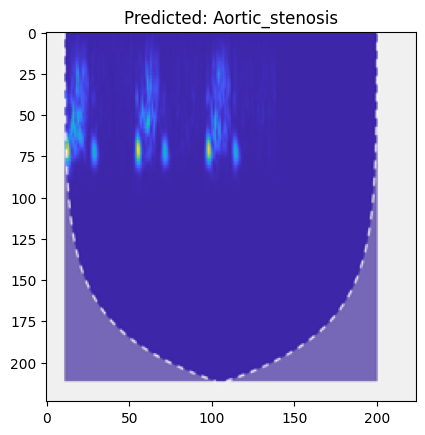

In [ ]:
# Step 1: Install necessary libraries (if needed)
!pip install tensorflow h5py

# Step 2: Import necessary modules
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt

# Step 3: Mount Google Drive to access files
drive.mount('/content/drive')

# Step 4: Define file paths (Update these paths as per your Drive folder structure)
model_path = '/content/drive/MyDrive/CWT/model_weightsProject.keras' # Path to your .keras model
image_path = '/content/drive/MyDrive/output_imagesSNR5/test/Aortic_stenosis/Aortic_stenosis_161.png'  # Path to your test image

# Step 5: Load the model
model = tf.keras.models.load_model(model_path)

# Step 6: Load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image with the target size
    img_array = image.img_to_array(img)  # Convert the image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 224, 224, 3)
    img_array = img_array / 255.0  # Normalize the image to [0, 1]
    return img_array

# Preprocess the image
img_array = load_and_preprocess_image(image_path)

# Step 7: Make prediction
prediction = model.predict(img_array)

# Step 8: Decode the prediction
class_indices = {'Aortic_stenosis': 0, 'Mitral_regurgitation': 1, 'Mitral_stenosis': 2, 'Mitral_valve_prolapse': 3, 'normal': 4}  # Update with your actual classes
predicted_class = np.argmax(prediction, axis=1)[0]

# Invert the class indices dictionary to map class index back to the class label
class_labels = {v: k for k, v in class_indices.items()}

# Step 9: Display the result
print(f"Predicted class: {class_labels[predicted_class]}")

# Step 10: Visualize the image with the predicted class
img = image.load_img(image_path)  # Reload the image to display
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 200 images belonging to 5 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9035 - loss: 0.3094 
Test Loss: 0.40841853618621826
Test Accuracy: 0.8949999809265137
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


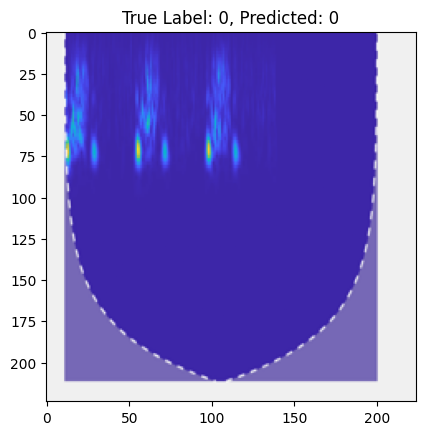

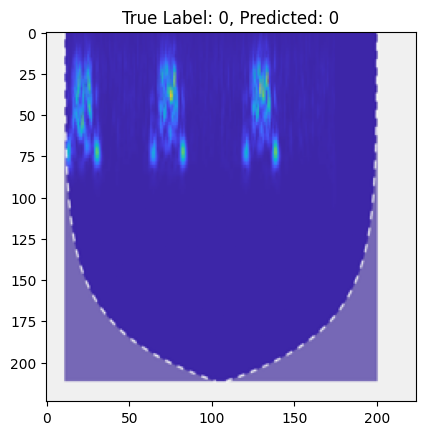

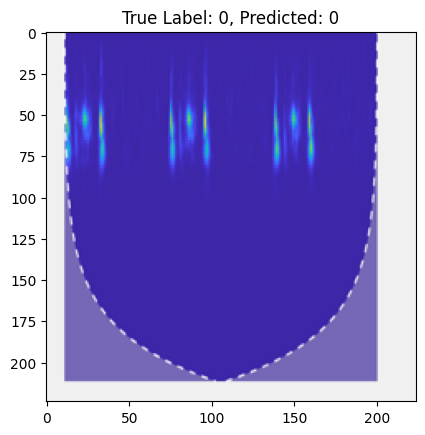

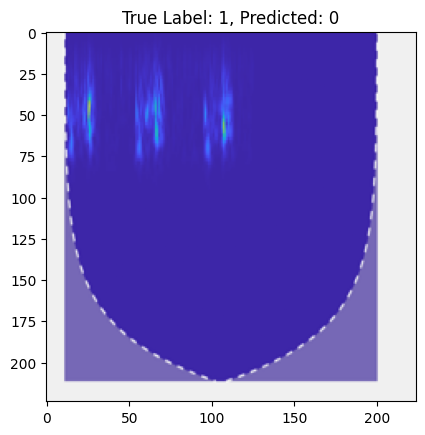

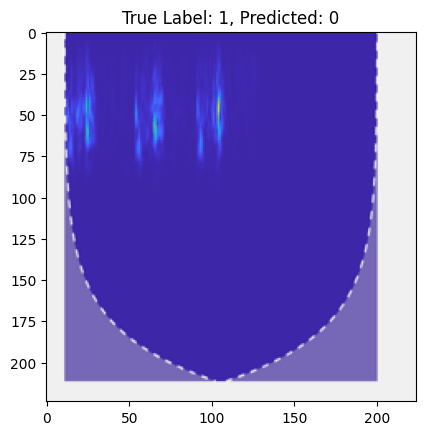

In [ ]:
# Step 1: Install necessary libraries (if needed)
!pip install tensorflow h5py

# Step 2: Import necessary modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from google.colab import drive

# Step 3: Mount Google Drive to access files
drive.mount('/content/drive')

# Step 4: Define file paths (Update these paths as per your Drive folder structure)
model_path = '/content/drive/MyDrive/CWT/model_weightsProject.keras'  # Path to your .keras model
test_loc = '/content/drive/MyDrive/output_imagesSNR5/test'  # Path to your test images

# Step 5: Load the model
model = tf.keras.models.load_model(model_path)

# Step 6: Prepare the test data
test_data_gen = ImageDataGenerator(rescale=1./255)  # Normalize images
test_data = test_data_gen.flow_from_directory(directory=test_loc,
                                              target_size=(224, 224),  # Image size used in training
                                              batch_size=16,
                                              class_mode='categorical',  # Assuming categorical classification
                                              shuffle=False)  # Don't shuffle for testing

# Step 7: Evaluate the model
# You can either use evaluate (to get accuracy and loss) or predict (to get individual predictions)
results = model.evaluate(test_data, verbose=1)

# Step 8: Display the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Step 9: (Optional) Predict individual test images
predictions = model.predict(test_data)

# Step 10: (Optional) Display some sample predictions
import matplotlib.pyplot as plt
for i in range(5):  # Display first 5 test samples with their predictions
    img, label = test_data[i]  # Get the test image and label
    plt.imshow(img[0])  # Show the image
    plt.title(f"True Label: {np.argmax(label[0])}, Predicted: {np.argmax(predictions[i])}")
    plt.show()
